<a href="https://colab.research.google.com/github/meethariprasad/Data-Science/blob/master/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Process**


In [0]:
import tensorflow as tf

from IPython.display import Image
from IPython.core.display import Image, display
img='https://upload.wikimedia.org/wikipedia/commons/b/b9/CRISP-DM_Process_Diagram.png'
display(Image(url=img, width=400, unconfined=True))

# **Business Understanding**

Problem Statement 1: Feedback Analysis: Unstructured feedback data for organization XYZ is scraped
from an online source. The leadership wants to know general sentiments from the feedbacks of
employees and the areas where they are doing good or needs improvement.
Analyze the feedback comments provided as part of the dataset. Provide recommendations on what XYZ
should look to Start, Stop or Continue doing.
Deliverables:

1. Your Code
2. Presentation explaining:

    a. The approach, methodology and the solution
    
    b. Data Backed Insights.
    
    c. Data Visualization (You may use Tableau/Qlik/Power Bi etc.)

#### **Problem in Machine Learning Language:**

For ML we can convert it as 3 step problem. Post data cleansing, data is mixture of possitive, negative statements. 

First we will use sentiment analysis to get the sentiment of Possitive, Neutral, Negative Statements. We will ignore neutrality aspect for now.

###### **Word Cloud Based Simple Analysis**

Once we have sentiments, then we can do word cloud analysis of negative and possitive sentiments seperately and get an high level overview of Possitive and Negative aspects to suggest management.


##### **Transfer Learning|Clustering|Keyphrase Extraction Based Analysis**

Possitive and Negative sentiments can be clustered seperately as is or on extracted key phrases through Transfer Learning based embedding and DBScan, a good unsupervised clustering algorithm. 

The cluster key phrases then can give good insights on where to concentrate, also cluster size can provide an estimation of size of issue.


# **Data Understanding**

In [0]:
import os
os.getcwd()

'/content'

In [0]:
import os
os.getcwd()
#%%Loading data


import numpy as np
import pandas as pd

# file_name='Feedbacks.csv'
#Add 'feedbacks' as header in first row
# data=pd.read_csv(file_name)

import io
data=pd.read_csv('https://raw.githubusercontent.com/meethariprasad/research_works/master/Feedbacks.csv')
data

,feedbacks
0,fun work most of the time
1,Very Little Work Life Balance
2,"organizations is an amazing place to work, lea..."
3,"Bright and engaging people, amazing financial ..."
4,perks (lots of free stuff)
...,...
1991,They tend to hire leadership straight out of c...
1992,The culture is amazing! What you read in the a...
1993,The company is a lot bigger than it used to be...
1994,People always have helpful advice for you. You...


# **Data Preperation**


In [0]:
#Removing NA
data=data.dropna()
#Found some #NAME? junk removing
data=data[~data['feedbacks'].str.contains('#NAME?')].dropna().reset_index(drop=True)
data.head(2)

,feedbacks
0,fun work most of the time
1,Very Little Work Life Balance


In [0]:
#Basic Text Cleansing. Can be improved further if needed.
def clean_text(row):
    import re
    string=row['feedbacks']
    #Remove all alphabetic characters
    cleansed_string=re.sub('[^A-Za-z]+', ' ', string)
    return cleansed_string
data['feedbacks']=data.apply(clean_text,axis=1)
data

,feedbacks
0,fun work most of the time
1,Very Little Work Life Balance
2,organizations is an amazing place to work lear...
3,Bright and engaging people amazing financial a...
4,perks lots of free stuff
...,...
1961,They tend to hire leadership straight out of c...
1962,The culture is amazing What you read in the ar...
1963,The company is a lot bigger than it used to be...
1964,People always have helpful advice for you You ...


# **Modeling**


Sentiment Analysis is a tough area and not a completely solved NLP problem.

There are different approaches like deeplearning based transfer learning, classification, VADER, Textblobs deployed for sentiment analysis and each does good in portions, without having an universally accepted model.

Excellent Article: https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4

Subjectively, results are debatable.

We are taking text blob, in the interest of time and quick solution prototype. This portion of the solution can be improved further with deep learning, in sentiment function given below


You can see the differences below of text blob and vader. You can note the failures|debatable results alternatiely.


In [0]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
analyzer = SentimentIntensityAnalyzer()

sentence="nothing good to say"
vs = analyzer.polarity_scores(sentence)
print ("\n {:-<65} {}".format(sentence, str(vs)))
print (TextBlob(sentence).sentiment)

sentence="Very Little Work Life Balance"
vs = analyzer.polarity_scores(sentence)
print ("\n {:-<65} {}".format(sentence, str(vs)))
print (TextBlob(sentence).sentiment)


 nothing good to say---------------------------------------------- {'neg': 0.445, 'neu': 0.555, 'pos': 0.0, 'compound': -0.3412}
Sentiment(polarity=0.7, subjectivity=0.6000000000000001)

 Very Little Work Life Balance------------------------------------ {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Sentiment(polarity=-0.24375000000000002, subjectivity=0.65)


In [0]:
import numpy as np
def sentiment(row):
  from textblob import TextBlob
  sentence=row['feedbacks']
  polarity=TextBlob(sentence).sentiment[0]
  if (polarity<0):
    return_value='Negative'
  else:
    return_value='Possitive'
  return return_value
data['sentiment']=data.apply(sentiment,axis=1)
data

,feedbacks,sentiment
0,fun work most of the time,Possitive
1,Very Little Work Life Balance,Negative
2,organizations is an amazing place to work lear...,Possitive
3,Bright and engaging people amazing financial a...,Possitive
4,perks lots of free stuff,Possitive
...,...,...
1961,They tend to hire leadership straight out of c...,Possitive
1962,The culture is amazing What you read in the ar...,Possitive
1963,The company is a lot bigger than it used to be...,Possitive
1964,People always have helpful advice for you You ...,Possitive


**Get Key Phrases through Rake**


In [0]:
!pip install rake-nltk
from rake_nltk import Rake

In [0]:
def scope_to_keyphrase(row):
    scopes=row['feedbacks']
    #https://www.researchgate.net/publication/227988510_Automatic_Keyword_Extraction_from_Individual_Documents
    from rake_nltk import Rake
    r = Rake() # Uses stopwords for english from NLTK, and all puntuation characters.

    r.extract_keywords_from_text(scopes)

    phrases=r.get_ranked_phrases()[0:3]
    return ' '.join(phrases) # To get keyword phrases ranked highest to lowest. Top 3
data['phrases']=data.apply(scope_to_keyphrase,axis=1)
data['phrases']

0                                           fun work time
1                                little work life balance
2       years organizations pays well salary bonus one...
3       non financial benefits healthy work life balan...
4                                   perks lots free stuff
                              ...                        
1961    meet unattainable goals hire leadership straig...
1962    feel comfortable around day monday friday offe...
1963                  lot bigger longer true help slowing
1964            really learn people always helpful advice
1965                           good food amazing ppl work
Name: phrases, Length: 1966, dtype: object

In [0]:
negative=data[data['sentiment']!='Possitive'].reset_index(drop=True)
possitive=data[data['sentiment']=='Possitive'].reset_index(drop=True)

In [0]:
# sentence='organizations is an amazing place to work learn and grow quickly Your peers are best in class and you will learn more in one year than you will at other companies in years organizations pays well through salary bonus and most importantly stock'
!python -m textblob.download_corpora
from textblob import TextBlob
# TextBlob(sentence).noun_phrases

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


# **Evaluation**

**Simple Word Cloud Based Key Issue/Possitives Analysis**


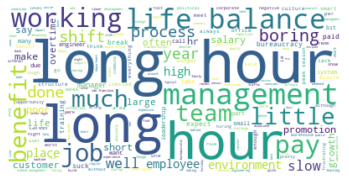

In [0]:
#Negative Word Cloud
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

negative_feedback_text = " ".join(feedback for feedback in negative.phrases)
negative_blob = TextBlob(negative_feedback_text)
negative_feedback_text=negative_blob.words.lemmatize().lower()
negative_feedback_text= " ".join(x for x in negative_feedback_text)

# negative_feedback_text = " ".join(feedback for feedback in negative.feedbacks)
# negative_feedback_text

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["work","day", "everyone","big","lot","company",'sometimes','hard','time','difficult','bad','people','wa','ha','really','don','terrible','organization','nothing','thing'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(negative_feedback_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams['figure.dpi'] = 200
plt.show()

**Negative Word Cloud Analysis**

Negative word cloud indicating us that key issues for people are found to be around broadly on following categories:

1. Work life balance, Long hours of work
2. Management|bureaucracy treatment/communication with people
3. Payment issues
4. Boring work|lack of opportunities
5. Career Promotion and Growth related issues
6. Commutation
7. Manager


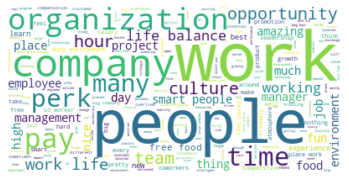

In [0]:
#Possitive Word Cloud
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

possitive_feedback_text = " ".join(feedback for feedback in possitive.phrases)
possitive_blob = TextBlob(possitive_feedback_text)
#Lemmatization and lowering case
possitive_feedback_text=possitive_blob.words.lemmatize().lower()
possitive_feedback_text= " ".join(x for x in possitive_feedback_text)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["great", "good","will","awesome","always",'may','benefit','lot','wa','don','really'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(possitive_feedback_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams['figure.dpi'] = 200
plt.show()

**Possitive Word Cloud Analysis**

Negative word cloud indicating us that key possitives for people, are found to be around broadly on following categories:

1. Teams with smart people and great coworkers
2. Overall Culture is being appreciated.
2. Work life balance. 
As this was also in negative comments, looks like management need to learn best practices from the respective business unit where this point is good and implement where it is not.
3. Payment and Benefits
As this was also in negative comments, looks like management need to learn best practices from the respective business unit where this point is good and implement where it is not.
5. Fun in workplace
6. Challenging work nature
7. Learning opportunities
8. Manager
9. Food

**Complex Analysis based on Transfer Learning|Clustering|Key Phrase Extraction**

We can further try to get some sense of quantification in to the negative and possitive sentiments, through unsupervised clustering and getting keyphrases out of it.

It will be interesting to see the results.


In [0]:
## Get Embeddings for Phrases. You can do for sentences too, but seen poor performance on small data during clustering, may due to sparsity of dimensions.
import tensorflow as tf
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2")
embeddings = embed(data['phrases'].values.tolist())
embedding_frame=pd.DataFrame(embeddings.numpy()).reset_index(drop=True)
data=data.reset_index(drop=True)
data_embeddings=pd.concat([data,embedding_frame],axis=1)
data_embeddings.head(2)

,feedbacks,sentiment,phrases,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,fun work most of the time,Possitive,fun work time,0.126350,0.296251,-0.035836,-0.059160,-0.080284,0.01086,0.222769,-0.218761,-0.511231,0.088383,0.14306,0.028443,-0.063716,0.146479,0.028373,-0.112966,-0.141421,-0.269935,0.153131,-0.101945,0.039063,0.156313,-0.099945,0.196109,-0.048809,0.073310,-0.089374,-0.066325,0.235741,-0.005621,-0.145779,-0.251919,0.177328,-0.000433,-0.059143,0.098910,0.280708,0.051695,-0.062654,-0.080238,-0.018392,0.293261,0.235269,0.045169,-0.027433,0.073533,-0.020442,-0.096461,0.284019,0.268927
1,Very Little Work Life Balance,Negative,little work life balance,0.202987,-0.119854,0.030915,-0.004972,-0.093453,-0.17462,0.160397,-0.143113,-0.424026,0.263226,0.28198,-0.061361,0.127406,0.227047,0.028586,-0.259140,-0.052658,0.007740,-0.052930,-0.127625,-0.049456,0.180800,0.128719,-0.196945,-0.092052,0.130199,0.156555,0.218912,0.312735,-0.169290,0.069850,0.089537,0.066241,0.079224,-0.152274,0.113952,0.205977,-0.041745,-0.180039,-0.176698,-0.082979,0.337688,0.073068,0.343518,-0.311288,-0.064042,-0.140407,0.020822,0.246810,0.271286


In [0]:
negative=data_embeddings[data_embeddings['sentiment']!='Possitive'].reset_index(drop=True)
possitive=data_embeddings[data_embeddings['sentiment']=='Possitive'].reset_index(drop=True)

In [0]:
negative_embeddings=negative.drop(columns=['feedbacks','sentiment','phrases'])
possitive_embeddings=possitive.drop(columns=['feedbacks','sentiment','phrases'])

Estimated number of clusters: 13
Estimated number of noise points: 316
Silhouette Coefficient: -0.134


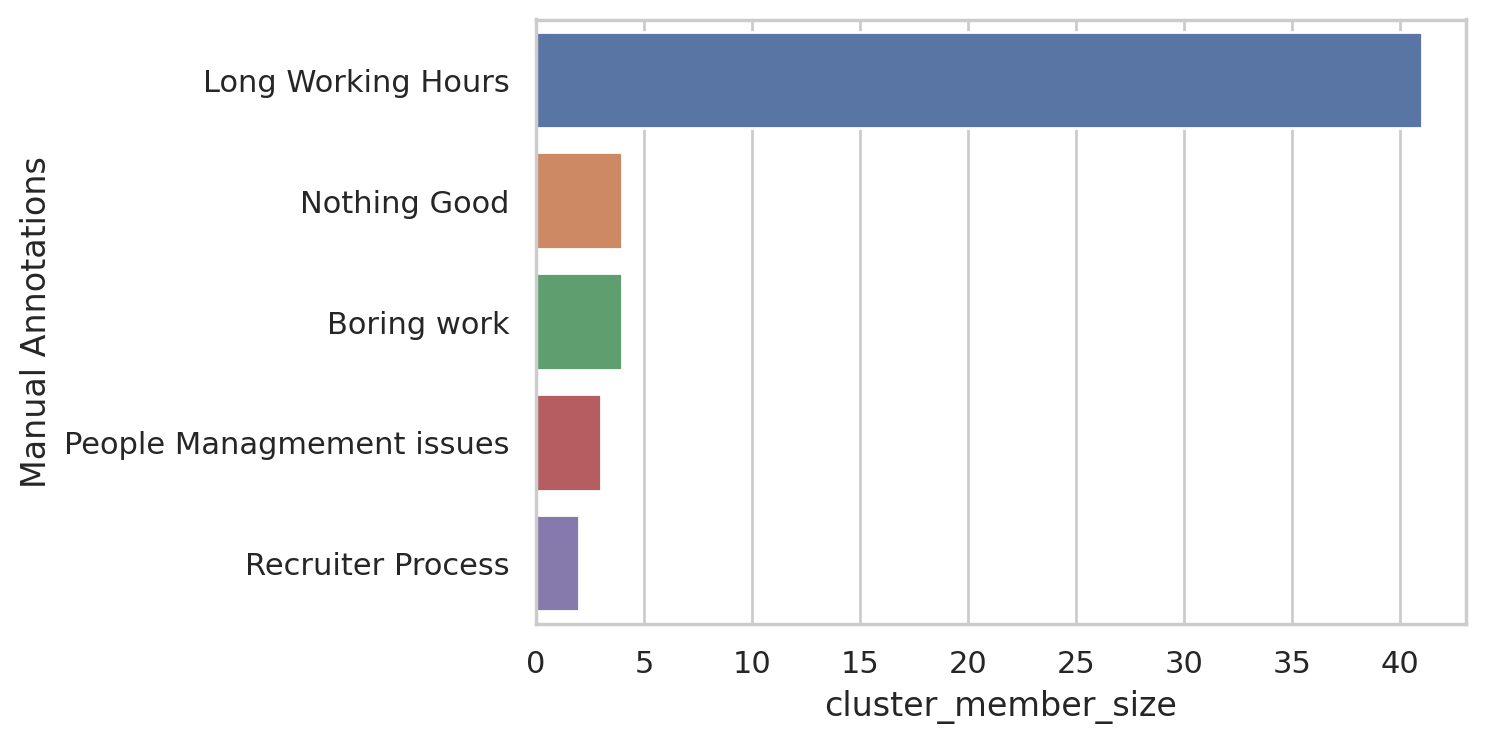

In [0]:
#Negative Clusters
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Compute DBSCAN
db = DBSCAN(eps=0.8, min_samples=2).fit(negative_embeddings)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score
#1 is good -1 is bad
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(negative_embeddings, labels))
negative['labels']=labels
# print (negative.groupby(['labels']).size())
negative[negative['labels']==0]['phrases'].tolist()

#Get Cluster Level Key Phrases and Assign it to Cluster Labels

my_clusters=negative.groupby('labels').size()
my_clusters=pd.DataFrame({'clusters':my_clusters.index,'count':my_clusters.values})
my_clusters=my_clusters.sort_values(by='count',ascending=False)
group_phrases=[]
for cluster_num in my_clusters['clusters'].tolist():
    cluster_member_size=my_clusters[my_clusters['clusters']==cluster_num]['count'].tolist()[0]
    if cluster_num==-1:
      cluster_phrase='Noise'
    else:
      if cluster_member_size>4:
        from textblob import TextBlob
        cluster_phrase=list(set(negative[negative['labels']==cluster_num]['phrases'].tolist()))
        cluster_phrase=' '.join(cluster_phrase)
        cluster_phrase=list(set(TextBlob(cluster_phrase).noun_phrases))
        cluster_phrase=' '.join(cluster_phrase)
      else:
        cluster_phrase=list(set(negative[negative['labels']==cluster_num]['phrases'].tolist()))
        cluster_phrase=' '.join(cluster_phrase)
        from rake_nltk import Rake
        r = Rake() # Uses stopwords for english from NLTK, and all puntuation characters.

        r.extract_keywords_from_text(cluster_phrase)
        cluster_phrase=r.get_ranked_phrases()[0:1]
        cluster_phrase=' '.join(cluster_phrase)
    group_phrases.append([cluster_num,cluster_member_size,cluster_phrase])
clusters_phrases=pd.DataFrame(group_phrases,columns=['cluster number','cluster_member_size','top issues'])
pd.set_option('display.max_colwidth', -1)
clusters_phrases=clusters_phrases[clusters_phrases['cluster number']>=0]
top_clusters_phrases=clusters_phrases.sort_values(['cluster_member_size'],ascending=False).head(5)
top_clusters_phrases=top_clusters_phrases.reset_index(drop=True)
top_clusters_phrases[['top issues']]
manual_annotations=['Long Working Hours', 'Nothing Good','Boring work','People Managmement issues','Recruiter Process']
top_clusters_phrases['Manual Annotations']=pd.DataFrame(manual_annotations)


import seaborn as sns
sns.set(style="whitegrid")
issues = top_clusters_phrases
ax = sns.barplot(x="cluster_member_size", y="Manual Annotations", data=issues)

Estimated number of clusters: 46
Estimated number of noise points: 1424
Silhouette Coefficient: -0.209


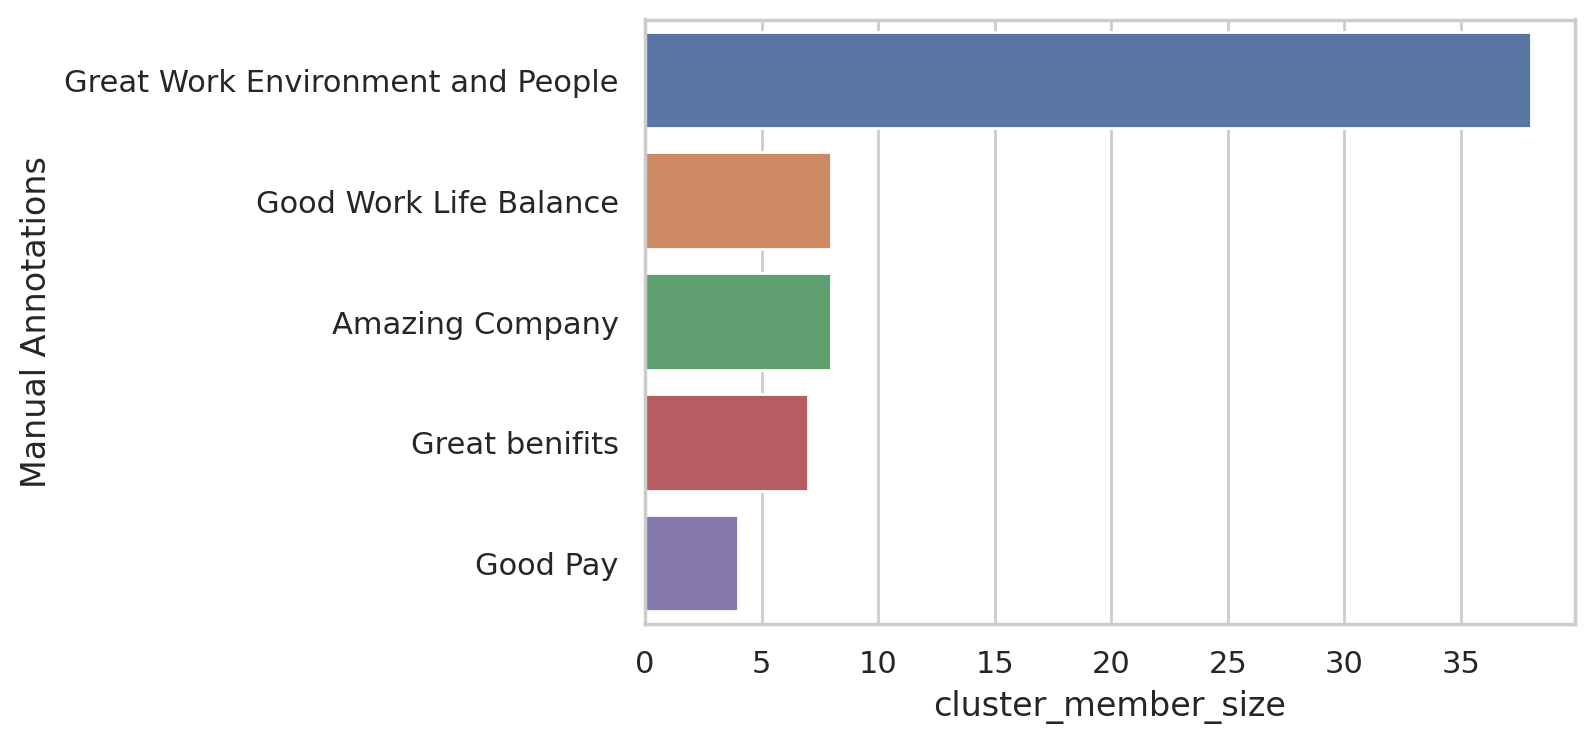

In [0]:
#Negative Clusters
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Compute DBSCAN
db = DBSCAN(eps=0.6, min_samples=2).fit(possitive_embeddings)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score
#1 is good -1 is bad
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(possitive_embeddings, labels))
possitive['labels']=labels
# print (possitive.groupby(['labels']).size())
possitive[possitive['labels']==0]['phrases'].tolist()

#Get Cluster Level Key Phrases and Assign it to Cluster Labels

my_clusters=possitive.groupby('labels').size()
my_clusters=pd.DataFrame({'clusters':my_clusters.index,'count':my_clusters.values})
my_clusters=my_clusters.sort_values(by='count',ascending=False)
group_phrases=[]
for cluster_num in my_clusters['clusters'].tolist():
    cluster_member_size=my_clusters[my_clusters['clusters']==cluster_num]['count'].tolist()[0]
    if cluster_num==-1:
      cluster_phrase='Noise'
    else:
      if cluster_member_size>4:
        from textblob import TextBlob
        cluster_phrase=list(set(possitive[possitive['labels']==cluster_num]['phrases'].tolist()))
        cluster_phrase=' '.join(cluster_phrase)
        cluster_phrase=list(set(TextBlob(cluster_phrase).noun_phrases))
        cluster_phrase=' '.join(cluster_phrase)
      else:
        cluster_phrase=list(set(possitive[possitive['labels']==cluster_num]['phrases'].tolist()))
        cluster_phrase=' '.join(cluster_phrase)
        from rake_nltk import Rake
        r = Rake() # Uses stopwords for english from NLTK, and all puntuation characters.

        r.extract_keywords_from_text(cluster_phrase)
        cluster_phrase=r.get_ranked_phrases()[0:3]
        cluster_phrase=' '.join(cluster_phrase)
    group_phrases.append([cluster_num,cluster_member_size,cluster_phrase])
clusters_phrases=pd.DataFrame(group_phrases,columns=['cluster number','cluster_member_size','top possitives'])
pd.set_option('display.max_colwidth', -1)
clusters_phrases=clusters_phrases[clusters_phrases['cluster number']>=0]
top_clusters_phrases=clusters_phrases.sort_values(['cluster_member_size'],ascending=False).head(5)
top_clusters_phrases=top_clusters_phrases.reset_index(drop=True)
top_clusters_phrases[['top possitives']]
manual_annotations=['Great Work Environment and People', 'Good Work Life Balance','Amazing Company','Great benifits','Good Pay']
top_clusters_phrases['Manual Annotations']=pd.DataFrame(manual_annotations)

import seaborn as sns
sns.set(style="whitegrid")
issues = top_clusters_phrases
ax = sns.barplot(x="cluster_member_size", y="Manual Annotations", data=issues)

# **Appendix**

What can be tried out further or why something was not tried out yet?

1. Use Deep and Transfer Learning of sentiment analysis based on finetunes TF Hub module or Use Stanford NLP. But both has a problem with respect to negation. Intention was to build a quick prototype, in this assignment

2. DB Scan has parameters in distance metric. A grid search on distance metric keeping SL score is a good idea on theory but in practice has seen that a great SL score always doesn't mean good homogeneous clusters and reduce noise. In the interest of tie keeping the experiments of it aside now.

3. Some non useful comments like nothing good, nothing bad, can be removed carefully.
